In [2]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import ast
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.svm import LinearSVC
import torch
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from pickle import dump, load
import joblib

### Data

In [3]:

path = f'hidden_states/paired_testset_embeddings_{0}-{50}.csv'
df = pd.read_csv(path, index_col=0)
for i in range(50, 500, 50):
    path = f'hidden_states/paired_testset_embeddings_{i}-{i+50}.csv'
    temp = pd.read_csv(path)
    df = pd.concat([df, temp])


summaries = pd.read_csv("dataset/summaries_embeddings.csv", index_col= 0)

paired = pd.read_csv('dataset/paired_testset.csv', index_col=0)

testset = pd.read_csv('dataset/testset.csv', index_col=0)


### Functions

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline


clf1 = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)

clf2 = RandomForestClassifier(n_estimators = 1500, criterion = "entropy", oob_score = True, max_features= 1)

clf3 = KNeighborsClassifier()

clf4 = LogisticRegression(solver='liblinear')

clf5 = LinearSVC( random_state=42, tol=1e-5)

models = {
    "SGD": clf1,
    "RFT": clf2,
    "KNN" : clf3,
    "Logistic": clf4,
    "LinearSVC": clf5
}

def accuracies(trainX, trainY, testX, testY, models=models, feature_type=''):


    for key, model in models.items():

        model.fit(trainX, trainY)

        with open(f'models/{key}-{feature_type}.pkl', 'wb') as f:  # open a text file
            dump(model, f) 

        print(f"{key}: {model.score(testX, testY)}")

def cvAcurracies(X,y, models=models):

    for key, model in models.items():

        y_pred = cross_val_predict(model, X, y , cv=10)
        print(f"{key}")
        print(classification_report(y, y_pred , target_names=["Deny", "Grant"]))
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
        print(f"{key}=>tn:{tn}, fp:{fp}, fn:{fn}, tp:{tp}")



def getSingleBriefEmbeddings(brief_type, paired):
    embeddings_map = list(map( lambda x: convert_to_numpy(x) , paired[brief_type].to_list()))
    outcome_map = paired['outcome'].to_list()
    data_type_map = paired['data_type'].to_list()  
    data =  [] 
    outcomes = []
    data_types = []

    for index,embeddings in enumerate(embeddings_map):
        outcome = outcome_map[index]
        data_type = data_type_map[index]
        for embedding in embeddings: 
            data.append(embedding)
            outcomes.append(outcome)
            data_types.append(data_type)
    return np.array(data) , np.array(outcomes , dtype=str) , np.array(data_types , dtype=str)

# convert string to Torch array

def convert_to_numpy(embedding):
    return np.array(ast.literal_eval(embedding))



def getSingleBriefs(brief_type, paired=paired):
    supports_map = list(map( lambda x: ast.literal_eval(x) , paired[brief_type].to_list()))
    outcome_map = paired['outcome'].to_list()
    data_type_map = paired['data_type'].to_list()  
    data = []

    for index,documents in enumerate(supports_map):
        outcome = outcome_map[index]
        data_type = data_type_map[index]
        for document in documents: 
            data.append((document,outcome,data_type))

    return np.array(data, dtype=str)

def confusion_plot(true_labels, predicted_labels, classes, labels , normalize=False, title=None, cmap=plt.cm.Blues):

    plt.figure(figsize=(10, 10))
    matrix = confusion_matrix(true_labels, predicted_labels, labels=labels)

    sns.heatmap(matrix, cmap=cmap, annot=True,
                cbar = True, fmt=".1f",
                 xticklabels=classes["x"], 
                 yticklabels=classes["y"])
    class_names = ["No Match", "Match"]
    # Plot non-normalized confusion matri
    plt.xlabel("Predicted")
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()
    return matrix



### TFIDF

todo: convert Gordon's TFIDF's to format compatible to sklearns models this site might help : https://stackoverflow.com/questions/7922487/how-to-transform-numpy-matrix-or-array-to-scipy-sparse-matrix

question: Should i use different pipeplines / tfidfs for support and opposition?

In [32]:

# supports
    
support_data = getSingleBriefs('support')
oppose_data = getSingleBriefs('opposition')


In [33]:
# support

support_x = support_data[:,0]
support_target = support_data[:,1]

train = support_data[:,2] == 'train'
test = support_data[:,2] == 'test'

support_train_x = support_x[train]
support_train_target = support_target[train]
support_test_x = support_x[test]
support_test_target = support_target[test]


# opposition

oppose_x = oppose_data[:,0]
oppose_target = oppose_data[:,1]

train = oppose_data[:,2] == 'train'
test = oppose_data[:,2] == 'test'

oppose_train_x = oppose_x[train]
oppose_train_target = oppose_target[train]
oppose_test_x = oppose_x[test]
oppose_test_target = oppose_target[test]


labels = ["grant", "deny"]
classes = {"x": labels, "y": labels}

In [34]:
pipe = Pipeline([('count', CountVectorizer()),('tfid', TfidfTransformer())])

transformed_pipe = pipe.fit(support_x)

joblib.dump(transformed_pipe, 'pipes/support-tfidf.joblib')

support_count_train = transformed_pipe['count'].transform(support_train_x)

support_tfid_train = transformed_pipe.transform(support_train_x)

support_count_test = transformed_pipe['count'].transform(support_test_x)

support_tfid_test = transformed_pipe.transform(support_test_x)

accuracies(support_tfid_train, support_train_target, support_tfid_test, support_test_target, feature_type='support-tfidf')


SGD: 0.5598705501618123
RFT: 0.540453074433657
KNN: 0.5339805825242718
Logistic: 0.5210355987055016


/Users/oluwaseuncardoso/Desktop/Projects/venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC: 0.5760517799352751


In [40]:

# opposition

transformed_pipe = pipe.fit(oppose_x)

joblib.dump(transformed_pipe, 'pipes/oppose-tfidf.joblib')

oppose_count_train = transformed_pipe['count'].transform(oppose_train_x)

oppose_tfid_train = transformed_pipe.transform(oppose_train_x)

oppose_count_test = transformed_pipe['count'].transform(oppose_test_x)

oppose_tfid_test = transformed_pipe.transform(oppose_test_x)

accuracies(oppose_tfid_train, oppose_train_target, oppose_tfid_test, oppose_test_target, feature_type='opposition-tfidf')


SGD: 0.5945945945945946
RFT: 0.5371621621621622
KNN: 0.5067567567567568
Logistic: 0.597972972972973


/Users/oluwaseuncardoso/Desktop/Projects/venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC: 0.597972972972973


In [34]:
np.savetxt("support_train_target.csv", support_train_target, delimiter=",", fmt='%s')
np.savetxt("support_test_target.csv", support_test_target, delimiter=",", fmt='%s')

accuracy: 0.5631067961165048


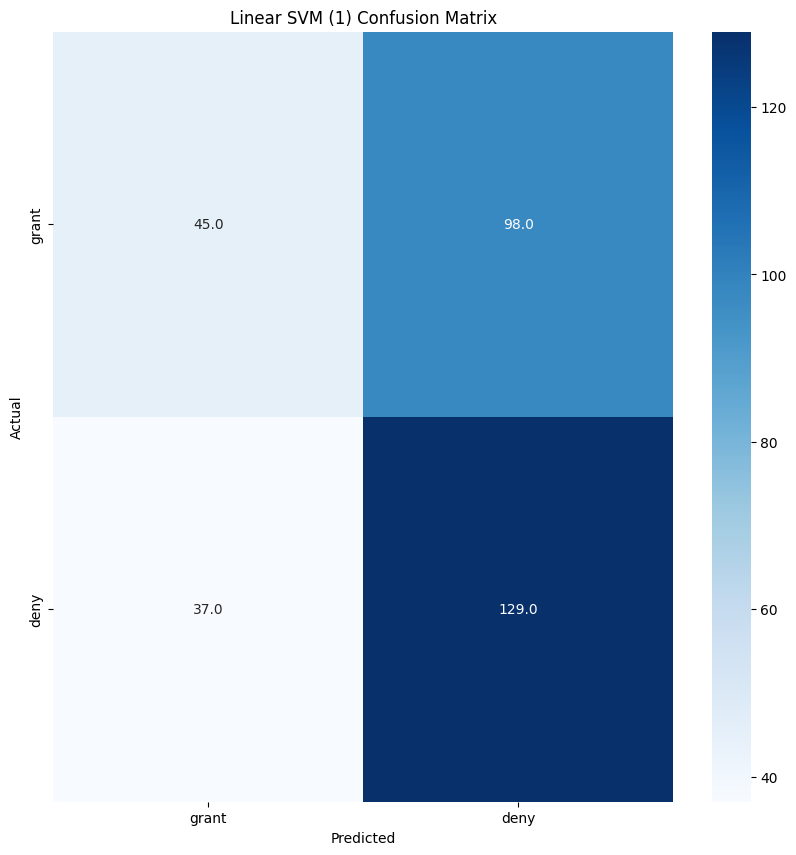

array([[ 45,  98],
       [ 37, 129]])

In [150]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                          alpha=1e-3, random_state=42,
                          max_iter=5, tol=None)),
])

text_clf.fit(support_train_x, support_train_target)
predicted = text_clf.predict(support_test_x)
print(f"accuracy: {np.mean(predicted == support_test_target)}")

confusion_plot(support_test_target, predicted, classes, labels=labels, normalize=False, title="Linear SVM (1) Confusion Matrix")

accuracy: 0.56957928802589


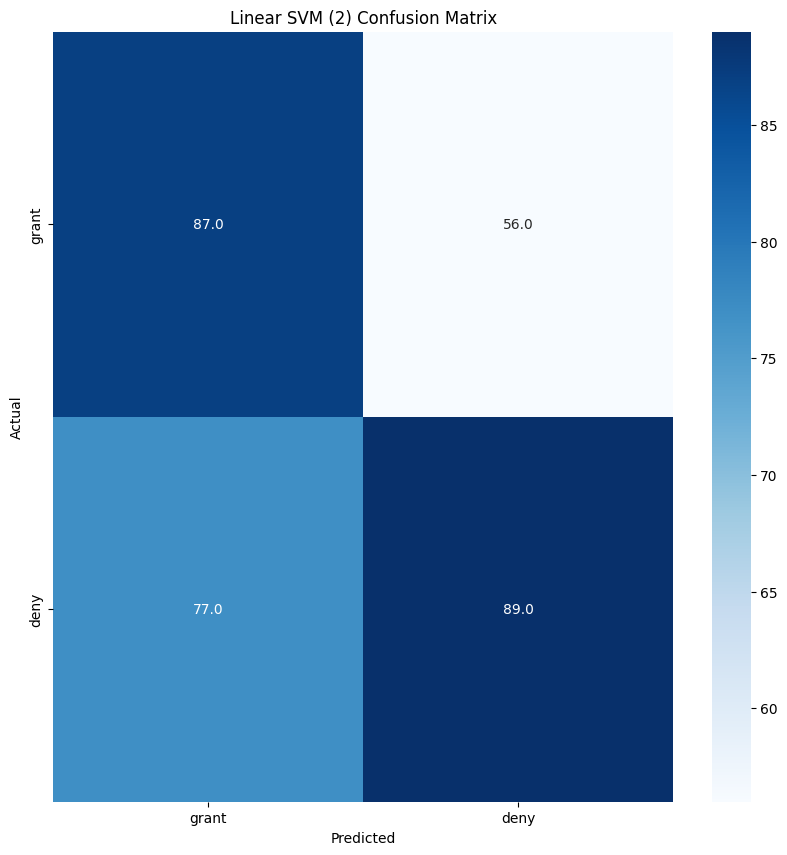

array([[87, 56],
       [77, 89]])

In [144]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC( random_state=42, tol=1e-5)),
])

text_clf.fit(support_train_x, support_train_target)
predicted = text_clf.predict(support_test_x)
print(f"accuracy: {np.mean(predicted == support_test_target)}")


confusion_plot(support_test_target, predicted, classes, labels=labels, normalize=False, title="Linear SVM (2) Confusion Matrix")

0.5275080906148867


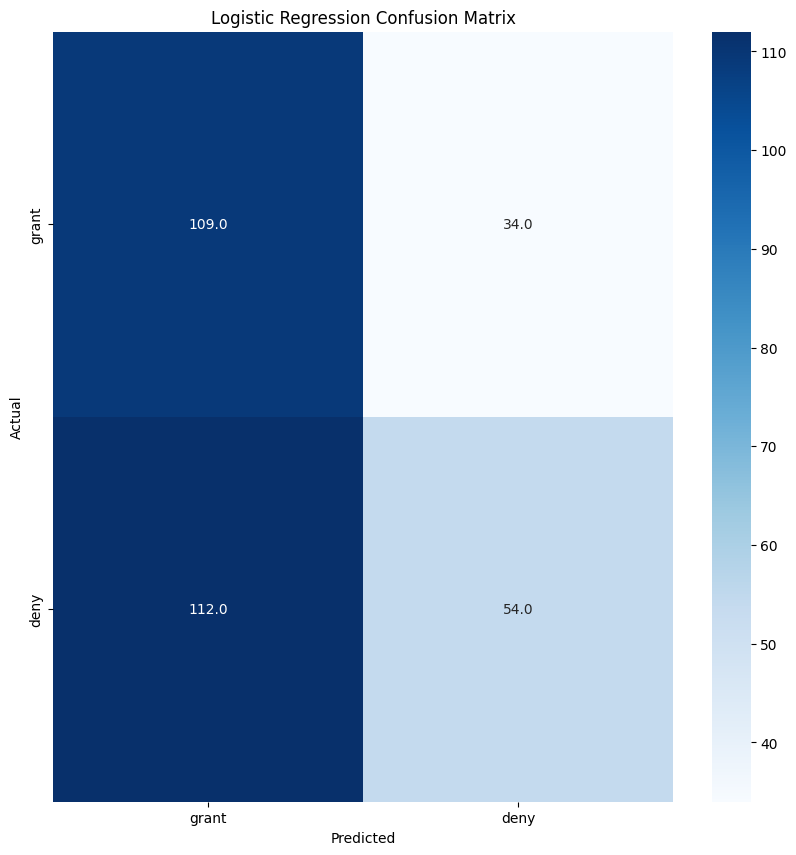

array([[109,  34],
       [112,  54]])

In [155]:

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('logistic',LogisticRegression(solver='liblinear')),
])

text_clf.fit(support_train_x, support_train_target)
predicted = text_clf.predict(support_test_x)
print(np.mean(predicted == support_test_target))
#print(f"probability: {text_clf.predict_proba(support_test_x)}")
confusion_plot(support_test_target, predicted, classes, labels=labels, normalize=False, title="Logistic Regression Confusion Matrix")

0.5533980582524272


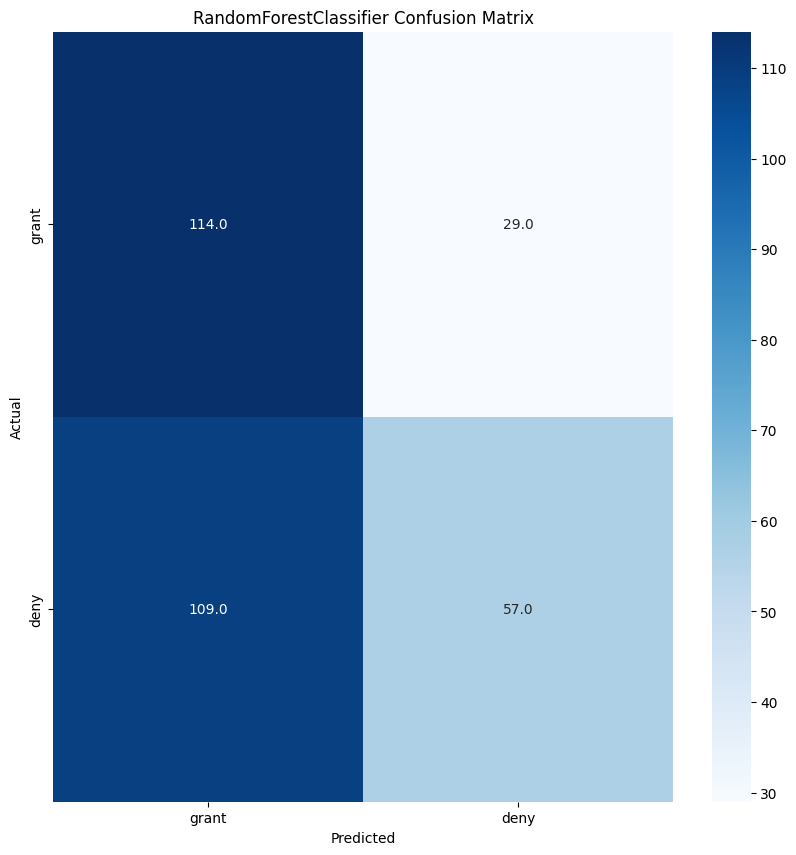

array([[114,  29],
       [109,  57]])

In [6]:

text_rft = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('RFT', RandomForestClassifier(n_estimators = 1500, criterion = "entropy", oob_score = True, max_features= 1)),
])

text_rft.fit(support_train_x, support_train_target)
predicted_rft = text_rft.predict(support_test_x)
print(np.mean(predicted_rft == support_test_target))
#print(f"probability: {text_clf.predict_proba(support_test_x)}")
confusion_plot(support_test_target, predicted_rft, classes, labels=labels, normalize=False, title="RandomForestClassifier Confusion Matrix")



In [9]:
with open('model.pkl', 'wb') as f:  # open a text file
    dump(text_rft, f) 

with open('model.pkl', 'rb') as f:
    new_clf = load(f)

In [10]:
for i in zip(text_rft.predict_proba(support_test_x) , text_rft.predict(support_test_x)):
    print(i)

(array([0.55333333, 0.44666667]), 'deny')
(array([0.49333333, 0.50666667]), 'grant')
(array([0.408, 0.592]), 'grant')
(array([0.53933333, 0.46066667]), 'deny')
(array([0.51, 0.49]), 'deny')
(array([0.478, 0.522]), 'grant')
(array([0.49466667, 0.50533333]), 'grant')
(array([0.52933333, 0.47066667]), 'deny')
(array([0.47333333, 0.52666667]), 'grant')
(array([0.448, 0.552]), 'grant')
(array([0.466, 0.534]), 'grant')
(array([0.42266667, 0.57733333]), 'grant')
(array([0.446, 0.554]), 'grant')
(array([0.45533333, 0.54466667]), 'grant')
(array([0.39666667, 0.60333333]), 'grant')
(array([0.53733333, 0.46266667]), 'deny')
(array([0.45466667, 0.54533333]), 'grant')
(array([0.44533333, 0.55466667]), 'grant')
(array([0.51533333, 0.48466667]), 'deny')
(array([0.43666667, 0.56333333]), 'grant')
(array([0.42733333, 0.57266667]), 'grant')
(array([0.26933333, 0.73066667]), 'grant')
(array([0.538, 0.462]), 'deny')
(array([0.37933333, 0.62066667]), 'grant')
(array([0.47666667, 0.52333333]), 'grant')
(arr

 accuracy 0.540453074433657


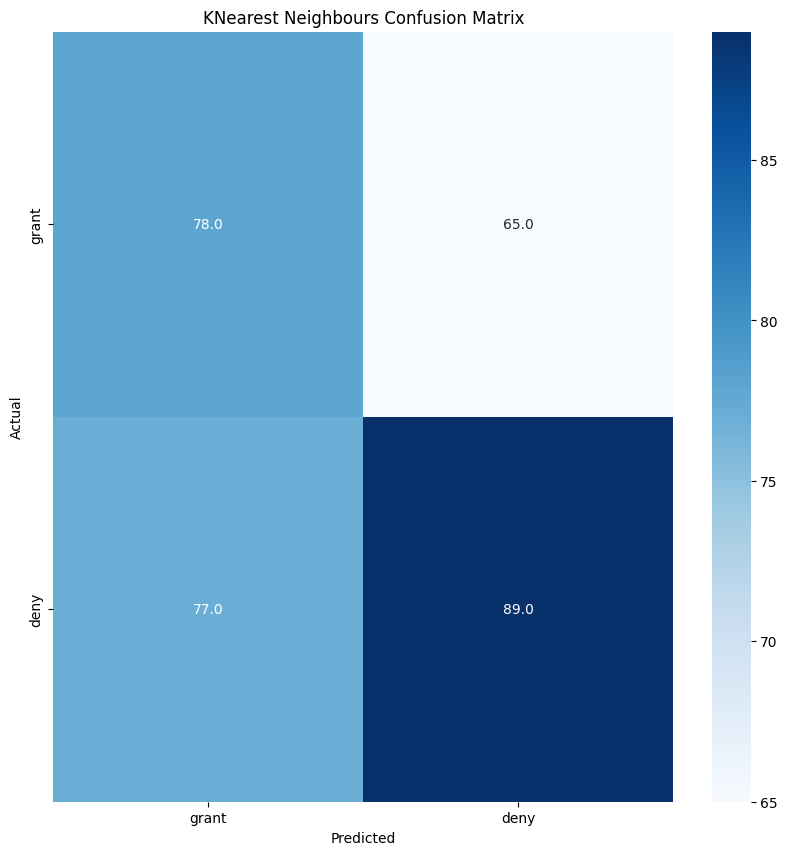

array([[78, 65],
       [77, 89]])

In [154]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('KNN', KNeighborsClassifier()),
])

text_clf.fit(support_train_x, support_train_target)
predicted = text_clf.predict(support_test_x)
print(f" accuracy {np.mean(predicted == support_test_target)}")
confusion_plot(support_test_target, predicted, classes, labels=labels, normalize=False, title="KNearest Neighbours Confusion Matrix")


### Embeddings

In [36]:
# Todo: verify if df is the sentence embeddings

support_mean_embeddings = getSingleBriefEmbeddings('support_first_embeddings', df)
X, Y, data_types = support_mean_embeddings


In [37]:

support_sentence_embeddings = getSingleBriefEmbeddings('support_embeddings', summaries)
support_X, support_Y, support_data_types = support_sentence_embeddings


train = support_data_types == 'train'
test = support_data_types == 'test'

support_train_x = support_X[train]
support_train_target = support_Y[train]
support_test_x = support_X[test]
support_test_target = support_Y[test]



opposition_sentence_embeddings = getSingleBriefEmbeddings('opposition_embeddings', summaries)
opposition_X, opposition_Y, opposition_data_types = opposition_sentence_embeddings


train = opposition_data_types == 'train'
test = opposition_data_types == 'test'

opposition_train_x = opposition_X[train]
opposition_train_target = opposition_Y[train]
opposition_test_x = opposition_X[test]
opposition_test_target = opposition_Y[test]


In [38]:


accuracies(support_train_x, support_train_target, support_test_x, support_test_target,feature_type='support-sentence_embeddings')

SGD: 0.5469255663430421
RFT: 0.5533980582524272
KNN: 0.5469255663430421
Logistic: 0.5922330097087378
LinearSVC: 0.540453074433657


/Users/oluwaseuncardoso/Desktop/Projects/venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [39]:
accuracies(opposition_train_x, opposition_train_target, opposition_test_x, opposition_test_target,feature_type='opposition-sentence_embeddings')

SGD: 0.4594594594594595
RFT: 0.47635135135135137
KNN: 0.5101351351351351
Logistic: 0.44594594594594594
LinearSVC: 0.4560810810810811


/Users/oluwaseuncardoso/Desktop/Projects/venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [17]:
cvAcurracies(support_X, support_Y, )

SGD
              precision    recall  f1-score   support

        Deny       0.54      0.53      0.54       316
       Grant       0.54      0.54      0.54       314

    accuracy                           0.54       630
   macro avg       0.54      0.54      0.54       630
weighted avg       0.54      0.54      0.54       630

SGD=>tn:168, fp:148, fn:143, tp:171
RFT
              precision    recall  f1-score   support

        Deny       0.56      0.61      0.59       316
       Grant       0.57      0.52      0.55       314

    accuracy                           0.57       630
   macro avg       0.57      0.57      0.57       630
weighted avg       0.57      0.57      0.57       630

RFT=>tn:193, fp:123, fn:150, tp:164
KNN
              precision    recall  f1-score   support

        Deny       0.54      0.57      0.55       316
       Grant       0.54      0.51      0.53       314

    accuracy                           0.54       630
   macro avg       0.54      0.54      0.54 

/Users/oluwaseuncardoso/Desktop/Projects/venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/oluwaseuncardoso/Desktop/Projects/venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/oluwaseuncardoso/Desktop/Projects/venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/oluwaseuncardoso/Desktop/Projects/venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value

LinearSVC
              precision    recall  f1-score   support

        Deny       0.53      0.56      0.54       316
       Grant       0.53      0.50      0.52       314

    accuracy                           0.53       630
   macro avg       0.53      0.53      0.53       630
weighted avg       0.53      0.53      0.53       630

LinearSVC=>tn:176, fp:140, fn:156, tp:158


/Users/oluwaseuncardoso/Desktop/Projects/venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/oluwaseuncardoso/Desktop/Projects/venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/oluwaseuncardoso/Desktop/Projects/venv/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


In [57]:
cvAcurracies(opposition_X, opposition_Y, )

SGD
              precision    recall  f1-score   support

        Deny       0.51      0.74      0.60       306
       Grant       0.43      0.22      0.29       279

    accuracy                           0.49       585
   macro avg       0.47      0.48      0.44       585
weighted avg       0.47      0.49      0.45       585

SGD=>tn:226, fp:80, fn:219, tp:60
RFT
              precision    recall  f1-score   support

        Deny       0.53      0.84      0.65       306
       Grant       0.49      0.17      0.25       279

    accuracy                           0.52       585
   macro avg       0.51      0.51      0.45       585
weighted avg       0.51      0.52      0.46       585

RFT=>tn:258, fp:48, fn:232, tp:47
KNN
              precision    recall  f1-score   support

        Deny       0.52      0.61      0.56       306
       Grant       0.48      0.38      0.42       279

    accuracy                           0.50       585
   macro avg       0.50      0.50      0.49     

In [50]:
Y.shape

(585,)

In [ ]:
python3 p-script.py --data dataset/testset.csv --model_name KNN --feature tfidf

python3 p-script.py --data dataset/testset.csv --model_name KNN --feature sentence_embeddings


### Combination Deep Sets

https://github.com/dpernes/deepsets-digitsum

https://github.com/manzilzaheer/DeepSets/blob/master/DigitSum/image_sum.ipynb

https://paperswithcode.com/paper/deep-sets

https://github.com/lucidrains/perceiver-pytorch

https://www.youtube.com/watch?v=P_xeshTnPZg

https://paperswithcode.com/method/set-transformer

https://arxiv.org/pdf/1810.00825.pdf

https://arxiv.org/abs/1910.02421

https://arxiv.org/pdf/1703.06114.pdf

https://arxiv.org/pdf/2104.13478.pdf  --- read first